/home/dronelab/delaunay_rasterization


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Max value torch: 1.1771694421768188
Max value jax: 1.1773016452789307
Mean Error: 4.6517157898051664e-05
Max Error: 0.008095383644104004
Distortion torch: 1.285081386566162
Distortion jax: 1.4209398031234741
Torch


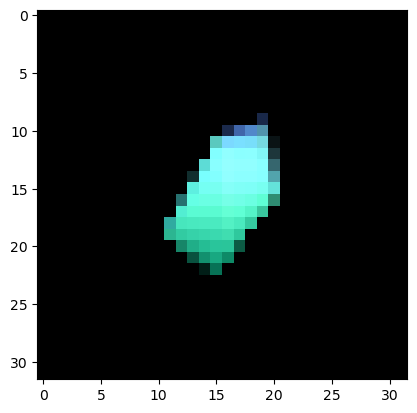

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GT


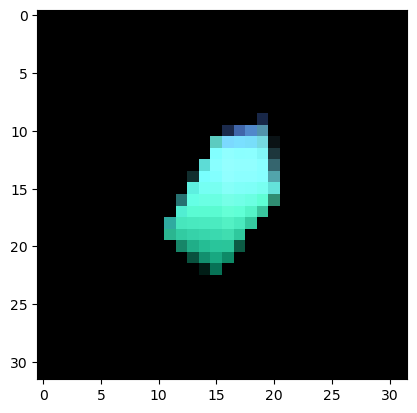

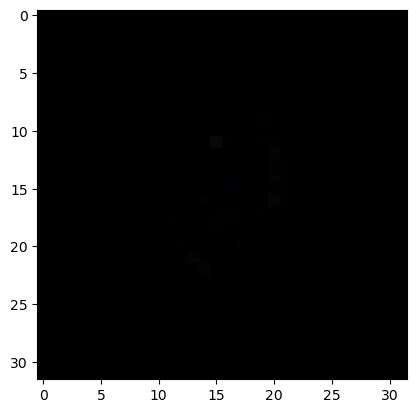

In [3]:
import os
VERSION = 9
if VERSION is not None:
    os.environ["CC"] = f"/usr/bin/gcc-{VERSION}"
    os.environ["CXX"] = f"/usr/bin/g++-{VERSION}"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
from pathlib import Path
import sys
sys.path.insert(0, str(Path(os.path.abspath('')).parent))
print(str(Path(os.path.abspath('')).parent))
import math
from utils.model_util import offset_normalize
from utils.topo_utils import calculate_circumcenters_torch


import torch
from utils.compare_quad import test_tetrahedra_rendering
import matplotlib.pyplot as plt
import numpy as np
from utils import topo_utils
from utils.test_util import compute_delaunay, generate_color_palette

import plotly.graph_objects as go
import numpy as np
torch.set_printoptions(precision=10)

vertices = torch.tensor([[ 2.0462048054,  6.0099563599, -2.7709932327],
        [ 9.2570934296, -3.4037013054, -0.6154882908],
        [-0.3192037344, -0.4060620070, -4.8382291794],
        [ 2.3484408855, -0.4595559835,  5.1750946045],
        [ 2.0315635204, -8.9080104828,  1.1725664139],
        [-5.5116777420, -4.8009209633, -4.7378311157],
        [-9.1555585861, -1.2241894007, -1.7154008150],
        [ 2.5718522072, -2.6496136189,  0.6982851028],
        [-0.3329432011, -1.1659097672, -2.4887781143],
        [ 1.0286951065, -5.4186248779, -1.0571700335]], device='cuda:0')
viewmat = torch.tensor([[-6.2930476665e-01, -5.1553761959e-01,  5.8154672384e-01,
          6.3674771786e-01],
        [ 8.2019373775e-02, -7.8817689419e-01, -6.0995894670e-01,
         -2.4096879959e+00],
        [ 7.7281844616e-01, -3.3615204692e-01,  5.3828763962e-01,
          1.2050601244e+00],
        [ 1.4261853920e-09, -2.2020444135e-08,  1.1744639039e-08,
          1.0000000000e+00]], device='cuda:0')
tile_size = 4
# vertices = torch.tensor([[ 82.0273742676, -18.4693813324, -24.9799900055],
#         [ 16.4444446564, -85.1786270142,  15.7476787567],
#         [-60.0876617432, -35.8836898804,  35.0280990601],
#         [ 15.8716678619,  43.5945396423, -47.4486351013],
#         [ 34.9284782410, -17.3868656158,  68.8305740356],
#         [  4.3706297874,  49.3245124817, -10.7796373367],
#         [ 16.6389236450, -73.1919784546,  -6.8073091507],
#         [  3.1552910805,  83.7309112549,  30.8407058716],
#         [-71.2365112305, -19.4960365295, -29.1383209229]], device='cuda:0')
# viewmat = torch.tensor([[ 8.4252923727e-01,  5.1259768009e-01,  1.6549350321e-01,
#          -3.1906810760e+01],
#         [ 4.8346698284e-01, -5.8417510986e-01, -6.5191972256e-01,
#           1.7828264236e+01],
#         [-2.3749534786e-01,  6.2927192450e-01, -7.4000871181e-01,
#           7.0171638489e+01],
#         [-3.7626676774e-10, -3.5134320453e-10, -1.6197504449e-10,
#           1.0000000000e+00]], device='cuda:0')
vertices = torch.tensor([[ 82.0273742676, -18.4693813324, -24.9799900055],
        [ 16.4444446564, -85.1786270142,  15.7476787567],
        [-60.0876617432, -35.8836898804,  35.0280990601],
        [ 15.8716678619,  43.5945396423, -47.4486351013],
        [ 34.9284782410, -17.3868656158,  68.8305740356],
        [  4.3706297874,  49.3245124817, -10.7796373367],
        [ 16.6389236450, -73.1919784546,  -6.8073091507],
        [  3.1552910805,  83.7309112549,  30.8407058716],
        [-71.2365112305, -19.4960365295, -29.1383209229]], device='cuda:0')
viewmat = torch.tensor([[ 4.8466959596e-01,  6.9743002484e-09,  8.7469732761e-01,
         -5.3091964722e+00],
        [-8.3697640896e-01,  2.9049822688e-01,  4.6376851201e-01,
          4.6586999893e+00],
        [ 2.5409808755e-01,  9.5687562227e-01, -1.4079564810e-01,
          1.0075272369e+02],
        [ 1.7310718414e-09,  1.8915113920e-10,  1.8520851519e-10,
          1.0000000000e+00]], device='cuda:0')

def augment(v):
    return torch.cat([v, torch.ones_like(v[:, :1])], dim=-1)

indices = compute_delaunay(vertices)
N = indices.shape[0]
all = generate_color_palette(N*2)[:, :3]
base_colors = all[:N].reshape(-1, 3)
raw_grd = (2*all[N:].reshape(-1, 3)-1) / math.sqrt(3)
tets = vertices[indices]
circumcenters, _ = calculate_circumcenters_torch(tets)
new_color, new_grd = offset_normalize(
    base_colors, raw_grd,
    circumcenters, tets)
# new_color = base_colors
tet_density = 0.1*torch.ones((len(indices),1), device='cuda')
# tet_density[1:] = 0
raw_cell_values = torch.cat([tet_density, new_color, new_grd.reshape(-1, 3)], dim=1)

results = test_tetrahedra_rendering(
    vertices.cuda(), indices, raw_cell_values, tet_density, viewmat,
    height=32, width=32, tile_size=16, fov=160, tmin=0.01)
    # height=16, width=16)
    # height=2, width=2)

# print(f"Vertex Torch Grad: {results['torch_vertex_grad']}")
# print(f"Vertex Jax Grad: {results['jax_vertex_grad']}")
# print(f"RGBS Torch Grad: {results['torch_rgbs_grad']}")
# print(f"RGBS Jax Grad: {results['jax_rgbs_grad']}")
print(f"Max value torch: {results['torch_image'].max()}")
print(f"Max value jax: {results['jax_image'].max()}")
print(f"Mean Error: {results['mean_error']}")
print(f"Max Error: {results['max_error']}")
print(f"Distortion torch: {results['torch_dist_loss']}")
print(f"Distortion jax: {results['jax_dist_loss']}")
# print(results['jax_dist_img'].max(), results['torch_dist_img'].max())
# print(results['extras']['dist_loss'].shape)
# jdist_img = results['jax_dist_img']
# plt.imshow(jdist_img)
# plt.show()
# dist_img = results['torch_dist_img']
# total_density = (dist_img[:, :, 2]**2).clip(min=1e-6)
# # print(total_density.max(), dist_img.reshape(-1, dist_img.shape[-1]).max(axis=0))
# dist_img = (((dist_img[:, :, 0] - dist_img[:, :, 1]) + dist_img[:, :, 4]) / total_density).clip(min=0)
# plt.imshow(dist_img)
# plt.show()
# print(dist_img.max(), jdist_img.max())
print("Torch")
plt.imshow(results['torch_image'])
plt.show()
print("GT")
plt.imshow(results['jax_image'][..., :3])
plt.show()
plt.imshow(5*np.abs(results['jax_image'][..., :3] - results['torch_image']))
plt.show()

In [2]:
from jaxutil.tetra_quad import lossfun_distortion

def update_distortion_state(old_state, weight, midpoint, interval_len):
    x, y, z, w, v = old_state

    x_new = x + 2.0 * weight * midpoint * z
    y_new = y + 2.0 * weight * w
    z_new = z + weight
    w_new = w + weight * midpoint
    v_new = v + (weight * weight) * (interval_len / 3.0)

    return np.array([x_new, y_new, z_new, w_new, v_new])

def incremental_distortion(t, w):
    """
    Compute the full distortion using the incremental approach,
    accumulating both cross-interval and intra-interval terms in one pass.

    Args:
      t: array of shape (N+1,) for interval boundaries
      w: array of shape (N,) for weights
    Returns:
      distortion: scalar = sum_{i,j} w_i w_j |m_i - m_j| + (1/3)*sum_i [w_i^2 * (t_{i+1}-t_i)]
    """
    # Midpoints
    midpoints = 0.5 * (t[:-1] + t[1:])
    intervals = (t[1:] - t[:-1])

    # Initialize the state = [x, y, z, w, v].
    state = np.zeros(5, dtype=np.float32)

    # Accumulate
    for i in range(len(w)):
        state = update_distortion_state(state, w[i], midpoints[i], intervals[i])
        print(i, state, w[i], t)

    # Unpack final state
    x, y, _, _, v = state
    # Cross-interval portion = (x - y)
    # Intra-interval portion = v
    return (x - y) + v

i, j = 0, 3
weights = results['extras']['total_density'][i, j, 0]
tdist = results['extras']['tdist'][i, j]
x = dist_img[i, j]
y = results['jax_dist_img'][i, j]
print(x, y)
# print(results['torch_extras']['alpha'][i, j])
# print(old_state)
# print(x, y)
print('ld', lossfun_distortion(tdist, weights))
xs, = np.where(weights > 1e-5)
start = tdist[np.min(xs)]
end = tdist[np.max(xs)]
print(start, end)
print('inc', incremental_distortion(np.array([start, end]), weights[0:1]))
plt.plot(tdist[:-1], weights, c='black')
plt.plot(tdist[:-1], weights, c='black')
plt.show()
# 0.000000-5.738485 (1.000000), (0.000000, 0.000000, 1.000000, 2.869242, 1.912828)

NameError: name 'dist_img' is not defined

In [ ]:
from jaxutil.tetra_quad import lossfun_distortion

def safe_exp(x):
    return np.exp(np.clip(x, a_min=None, a_max=20))

def moment_0_int(a, b, s1):
    return (1 - safe_exp(s1*(a - b)))/np.clip(s1, a_min=1e-8, a_max=None)
def moment_1_int(a, b, s1):
    return (a*s1 - (b*s1 + 1)*safe_exp(s1*(a - b)) + 1)/np.clip((s1**2), a_min=1e-8, a_max=None)

def self_dist(a, b, s):
    ds = s * (a-b)
    return (2 * s * (a-b) * safe_exp(ds) + 1 - safe_exp(2*ds)) / np.clip(s**3, a_min=1e-8, a_max=None)
    # return (2*s*(a - b)*safe_exp(s*(a + 2*b)) + safe_exp(3*b*s) - safe_exp(s*(2*a + b)))*safe_exp(-3*b*s)/np.clip((s**3), a_min=1e-8, a_max=None)

def update_distortion_state_int(state, t1, t2, sigma):
    x, y, z, w, v, T = state
    m0 = T*moment_0_int(t1, t2, sigma)
    m1 = T*moment_1_int(t1, t2, sigma)
    new_z = z + m0
    new_w = w + m1
    new_x = x + z * m1
    new_y = y + w * m0
    new_v = v + T*T*self_dist(t1, t2, sigma)
    # print(self_dist(t1, t2, sigma), t1, t2, sigma)
    alpha = 1-np.exp(-sigma*(t2-t1))
    new_T = T * (1-alpha)
    return np.array([new_x, new_y, new_z, new_w, new_v, new_T])

def incremental_distortion(t, sigma):
    state = np.zeros(6, dtype=np.float32)
    state[-1] = 1
    for i in range(len(sigma)):
        state = update_distortion_state_int(state, t[i], t[i+1], sigma[i])
    x, y, _, _, v, _ = state
    return 2*(x - y) + v 

i, j = 12, 12
weights = results['extras']['weights'][i, j, 0]
tdist = results['extras']['tdist'][i, j]
x = distortion_loss[i, j]
y = results['jax_dist_img'][i, j]
# print(results['torch_extras']['alpha'][i, j])
old_state = distortion_img[i, j]
# print(old_state)
# print(x, y)
print(lossfun_distortion(tdist, weights))
xs, = np.where(weights > 1e-5)
start = tdist[np.min(xs)]
end = tdist[np.max(xs)]
print(start, end)
old_state = np.zeros(6)
old_state[-1] = 1
# print(update_distortion_state(old_state, 1, (start+end)*0.5, end-start))
print(update_distortion_state_int(old_state, start, end, 1))
# print(update_distortion_state(old_state, 0, 10, 0))
# print(incremental_distortion(tdist, weights))
plt.plot(tdist[:-1], weights, c='black')
plt.show()

x = np.linspace(0, 10, 100)
plt.plot(x, self_dist(start, end, x))
plt.show()
print(start)
x = np.linspace(0, end-start, 100)
plt.plot(x, self_dist(start, start+x, 1))
plt.show()
x = np.linspace(0, start, 100)
plt.plot(x, self_dist(x, x-start+end, 1))
plt.show()
print(tet_density.max())


NameError: name 'distortion_loss' is not defined

NameError: name 'colors' is not defined

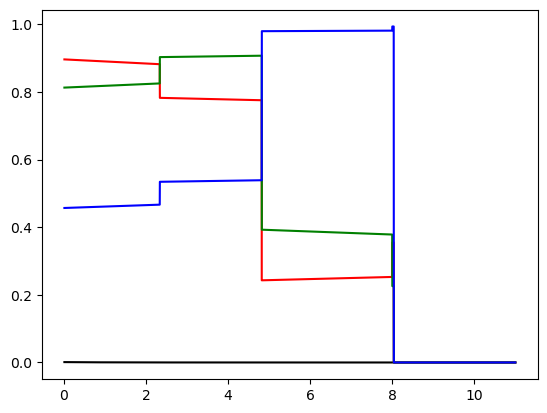

In [ ]:

# print((viewmat @ circumcenters.T)[:3].T)
# print(colors, indices)
i, j = 5, 5
k = 3
qcolors = results['extras']['avg_colors'][i, j, 0]
weights = results['extras']['weights'][i, j, 0]
tdist = results['extras']['tdist'][i, j]
N = min(tdist[tdist < 10000].shape[0], tdist.shape[0]-1)
plt.plot(tdist[:N], weights[:N], c='black')
plt.plot(tdist[:N], qcolors[:N, 0], c='red')
plt.plot(tdist[:N], qcolors[:N, 1], c='green')
plt.plot(tdist[:N], qcolors[:N, 2], c='blue')
plt.plot(tdist[:N], float(colors[k][0].cpu())*np.ones_like(tdist[:N]), c='red', linestyle=':')
plt.plot(tdist[:N], float(colors[k][1].cpu())*np.ones_like(tdist[:N]), c='green', linestyle=':')
plt.plot(tdist[:N], float(colors[k][2].cpu())*np.ones_like(tdist[:N]), c='blue', linestyle=':')
plt.show()


In [ ]:
import torch
import numpy as np
import plotly.graph_objects as go

# Define tensors provided
view_matrix = torch.tensor([
    [-6.2930476665e-01, -5.1553761959e-01,  5.8154672384e-01,  6.3674771786e-01],
    [ 8.2019373775e-02, -7.8817689419e-01, -6.0995894670e-01, -2.4096879959e+00],
    [ 7.7281844616e-01, -3.3615204692e-01,  5.3828763962e-01,  1.2050601244e+00],
    [ 1.4261853920e-09, -2.2020444135e-08,  1.1744639039e-08,  1.0000000000e+00]
], device='cpu')

tetra = torch.tensor([
    [-0.3329432011, -1.1659097672, -2.4887781143],
    [ 2.3484408855, -0.4595559835,  5.1750946045],
    [ 2.0462048054,  6.0099563599, -2.7709932327],
    [-9.1555585861, -1.2241894007, -1.7154008150]
], device='cpu')

# Compute camera origin from view matrix
R = view_matrix[:3, :3]
t = view_matrix[:3, 3]
camera_origin = -torch.linalg.inv(R) @ t

# The normal vector of the camera plane is the third row of the rotation matrix
plane_normal = R[2, :]

# Define the grid for the plane
plane_size = 10
x_plane = np.linspace(-plane_size, plane_size, 10)
y_plane = np.linspace(-plane_size, plane_size, 10)
xx, yy = np.meshgrid(x_plane, y_plane)

# Compute zz using plane equation: ax + by + cz + d = 0
# plane equation: normal . (X - camera_origin) = 0
a, b, c = plane_normal.numpy()
d = -(a * camera_origin[0].numpy() + b * camera_origin[1].numpy() + c * camera_origin[2].numpy())
zz = (-a * xx - b * yy - d) / c

# Plot using plotly
fig = go.Figure()

# Plot the plane
fig.add_trace(go.Surface(x=xx, y=yy, z=zz, opacity=0.5, colorscale='Blues', showscale=False))

# Plot the tetrahedron vertices
fig.add_trace(go.Scatter3d(
    x=[t[0]], y=[t[1]], z=[t[2]],
    mode='markers+text',
    marker=dict(size=5, color='red'),
    text=['origin'],
    textposition="top center"
))
# Plot the tetrahedron vertices
fig.add_trace(go.Scatter3d(
    x=tetra[:, 0].numpy(), y=tetra[:, 1].numpy(), z=tetra[:, 2].numpy(),
    mode='markers+text',
    marker=dict(size=5, color='red'),
    text=["v0", "v1", "v2", "v3"],
    textposition="top center"
))

# Define tetrahedron edges
edges = [(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]
for edge in edges:
    fig.add_trace(go.Scatter3d(
        x=tetra[edge, 0].numpy(),
        y=tetra[edge, 1].numpy(),
        z=tetra[edge, 2].numpy(),
        mode='lines',
        line=dict(color='black', width=2)
    ))

# Set the camera view
fig.update_layout(scene_camera=dict(
    eye=dict(x=camera_origin[0].item(), y=camera_origin[1].item(), z=camera_origin[2].item())
))

fig.update_layout(
    scene=dict(
        aspectmode='data'
    ),
    title="Camera-aligned Plane and Tetrahedron"
)

fig.show()
